# Predicting sentiment from product reviews


The goal of this notebook is to explore logistic regression using Stochastic Gradient Ascent.

In this notebook, you will use product review data from Amazon.com to predict whether the sentiments about a product (from its reviews) are positive or negative.

* Do some feature engineering
* Train a Stochastic logistic regression model to predict the sentiment of product reviews.
* Inspect the weights (coefficients) of a trained logistic regression model.
* Make a prediction (both class and probability) of sentiment for a new product review.
* Given the logistic regression weights, predictors and ground truth labels, write a function to compute the **accuracy** of the model.

Let's get started!

In [1]:
import pandas as pd
import numpy as np

# Data preparation

We will use a dataset consisting of Amazon.com product reviews.

In [2]:
products = pd.read_csv('../datasets/Amazon Product Reviews I.csv')

In [3]:
print(products.head())

                     id       asins   brand                  categories  \
0  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   
1  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   
2  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   
3  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   
4  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   

  colors             dateAdded           dateUpdated  \
0    NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   
1    NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   
2    NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   
3    NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   
4    NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   

                  dimension  ean                         keys  ...  \
0  169 mm x 117 mm x 9.1 mm  NaN  kindlepaperwhite/b00qjdu3ky  ...   
1  169 mm x 117 mm x 9.1 mm  NaN  kindlepaperwhite/b00qjdu3ky  ...   
2 

In [4]:
name=np.unique(products['name'])
print(name[0:10])

['Alexa Voice Remote for Amazon Echo and Echo Dot'
 'Alexa Voice Remote for Amazon Fire TV and Fire TV Stick'
 'All-New Amazon Fire 7 Tablet Case (7th Generation'
 'All-New Amazon Fire HD 8 Tablet Case (7th Generation'
 'All-New Amazon Fire TV Game Controller'
 'All-New Amazon Kid-Proof Case for Amazon Fire 7 Tablet (7th Generation'
 'All-New Amazon Kid-Proof Case for Amazon Fire HD 8 Tablet (7th Generation'
 'All-New Fire 7 Kids Edition Tablet' 'All-New Fire 7 Tablet with Alexa'
 'All-New Fire HD 8 Kids Edition Tablet']


Now, let us see a preview of what the dataset looks like.

In [5]:
# Simplify relevant columns names
if('reviews.rating' in products.columns):
    products['rating']=products['reviews.rating']
    products.drop(['reviews.rating'],axis=1, inplace=True)

if('reviews.text' in products.columns):
    products['reviews']=products['reviews.text']
    products.drop(['reviews.text'],axis=1, inplace=True)
    
if('reviews.title' in products.columns):
    products['title']=products['reviews.title']
    products.drop(['reviews.title'],axis=1, inplace=True)

# Drop irrelevant columns
relevant_cols=['reviews','rating','title']
products = products.loc[:, relevant_cols]

# Drop Nana
products.dropna(subset=['rating', 'reviews','title'], inplace=True)
products.reset_index(drop=True, inplace=True)

print(products.head())

                                             reviews  rating  \
0  I initially had trouble deciding between the p...     5.0   
1  Allow me to preface this with a little history...     5.0   
2  I am enjoying it so far. Great for reading. Ha...     4.0   
3  I bought one of the first Paperwhites and have...     5.0   
4  I have to say upfront - I don't like coroporat...     5.0   

                                        title  
0              Paperwhite voyage, no regrets!  
1           One Simply Could Not Ask For More  
2  Great for those that just want an e-reader  
3                    Love / Hate relationship  
4                                   I LOVE IT  


Let us explore a specific example of a Amazon product.

In [6]:
print(products['reviews'][269])

I can read a lot longer without pain in my hands since the cover holds it for me. Very nice shade of blue.


## Build the word count vector for each review

Now, we will perform 2 simple data transformations:

1. Remove punctuation using [Python's built-in](https://docs.python.org/2/library/string.html) string functionality.
2. Transform the reviews into word-counts.

**Aside**. In this notebook, we remove all punctuations for the sake of simplicity. A smarter approach to punctuations would preserve phrases such as "I'd", "would've", "hadn't" and so forth. See [this page](https://neptune.ai/blog/tokenization-in-nlp) for an example of smart handling of punctuations.

In [7]:
import string 
def remove_punctuation(text):
    try: # python 2.x
        text = text.translate(None, string.punctuation) 
    except: # python 3.x
        translator = text.maketrans('', '', string.punctuation)
        text = text.translate(translator)
    return text

products['reviews'] = products['reviews'].apply(remove_punctuation)
print(products['reviews'])

0       I initially had trouble deciding between the p...
1       Allow me to preface this with a little history...
2       I am enjoying it so far Great for reading Had ...
3       I bought one of the first Paperwhites and have...
4       I have to say upfront  I dont like coroporate ...
                              ...                        
1172    This is not the same remote that I got for my ...
1173    I have had to change the batteries in this rem...
1174    Remote did not activate nor did it connect to ...
1175    It does the job but is super over priced I fee...
1176    I ordered this item to replace the one that no...
Name: reviews, Length: 1177, dtype: object


In [8]:
# Word Importance: Frequency counts
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(products['reviews'])
word_count_df = pd.DataFrame(X_train_counts.toarray())
word_count_df = word_count_df.add_prefix('word_count_')
products = pd.concat([products, word_count_df], axis=1)
print(products.head())

                                             reviews  rating  \
0  I initially had trouble deciding between the p...     5.0   
1  Allow me to preface this with a little history...     5.0   
2  I am enjoying it so far Great for reading Had ...     4.0   
3  I bought one of the first Paperwhites and have...     5.0   
4  I have to say upfront  I dont like coroporate ...     5.0   

                                        title  word_count_0  word_count_1  \
0              Paperwhite voyage, no regrets!             0             0   
1           One Simply Could Not Ask For More             0             0   
2  Great for those that just want an e-reader             0             0   
3                    Love / Hate relationship             0             0   
4                                   I LOVE IT             0             0   

   word_count_2  word_count_3  word_count_4  word_count_5  word_count_6  ...  \
0             0             0             0             0             0 

In [9]:
# Word Importance: TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
print(X_train_tfidf.shape)

tfidf_df = pd.DataFrame(X_train_tfidf.toarray())
tfidf_df = word_count_df.add_prefix('tfidf_word_count_')
products = pd.concat([products, tfidf_df], axis=1)

print(products.head())

(1177, 6750)
                                             reviews  rating  \
0  I initially had trouble deciding between the p...     5.0   
1  Allow me to preface this with a little history...     5.0   
2  I am enjoying it so far Great for reading Had ...     4.0   
3  I bought one of the first Paperwhites and have...     5.0   
4  I have to say upfront  I dont like coroporate ...     5.0   

                                        title  word_count_0  word_count_1  \
0              Paperwhite voyage, no regrets!             0             0   
1           One Simply Could Not Ask For More             0             0   
2  Great for those that just want an e-reader             0             0   
3                    Love / Hate relationship             0             0   
4                                   I LOVE IT             0             0   

   word_count_2  word_count_3  word_count_4  word_count_5  word_count_6  ...  \
0             0             0             0             0  

Now, let us explore what the sample example above looks like after these 2 transformations. Here, each entry in the **word_count** column is a dictionary where the key is the word and the value is a count of the number of times the word occurs.

## Extract sentiments

We will **ignore** all reviews with *rating = 3*, since they tend to have a neutral sentiment.

In [10]:
products = products[products['rating'] != 3]
products.reset_index(drop=True, inplace=True)
products.shape

(1053, 13503)

Now, we will assign reviews with a rating of 4 or higher to be *positive* reviews, while the ones with rating of 2 or lower are *negative*. For the sentiment column, we use +1 for the positive class label and -1 for the negative class label.

In [11]:
products['sentiment'] = products['rating'].apply(lambda r : +1 if r > 3 else -1)
products.head()

reviews  rating  \
0  I initially had trouble deciding between the p...     5.0   
1  Allow me to preface this with a little history...     5.0   
2  I am enjoying it so far Great for reading Had ...     4.0   
3  I bought one of the first Paperwhites and have...     5.0   
4  I have to say upfront  I dont like coroporate ...     5.0   

                                        title  word_count_0  word_count_1  \
0              Paperwhite voyage, no regrets!             0             0   
1           One Simply Could Not Ask For More             0             0   
2  Great for those that just want an e-reader             0             0   
3                    Love / Hate relationship             0             0   
4                                   I LOVE IT             0             0   

   word_count_2  word_count_3  word_count_4  word_count_5  word_count_6  ...  \
0             0             0             0             0             0  ...   
1             0             0             0             0             0  ...   
2             0             0             0             0             0  ...   
3             0             0             0             0             0  ...   
4             0             0             0             0             0  ...   

   tfidf_word_count_word_count_6741  tfidf_word_count_word_count_6742  \
0                                 0                                 0   
1                                 0                                 0   
2                                 0                                 0   
3                                 0                                 0   
4                                 0                                 0   

   tfidf_word_count_word_count_6743  tfidf_word_count_word_count_6744  \
0                                 0                                 0   
1                                 0                                 0   
2                                 0                                 0   
3                                 0                                 0   
4                                 0                                 0   

   tfidf_word_count_word_count_6745  tfidf_word_count_word_count_6746  \
0                                 0                                 0   
1                                 0                                 0   
2                                 0                                 0   
3                                 0                                 0   
4                                 0                                 0   

   tfidf_word_count_word_count_6747  tfidf_word_count_word_count_6748  \
0                                 0                                 0   
1                                 0                                 0   
2                                 0                                 0   
3                                 0                                 0   
4                                 0                                 0   

   tfidf_word_count_word_count_6749  sentiment  
0                                 0          1  
1                                 0          1  
2                                 0          1  
3                                 0          1  
4                                 0          1  

[5 rows x 13504 columns]

array([[<Axes: title={'center': 'sentiment'}>]], dtype=object)

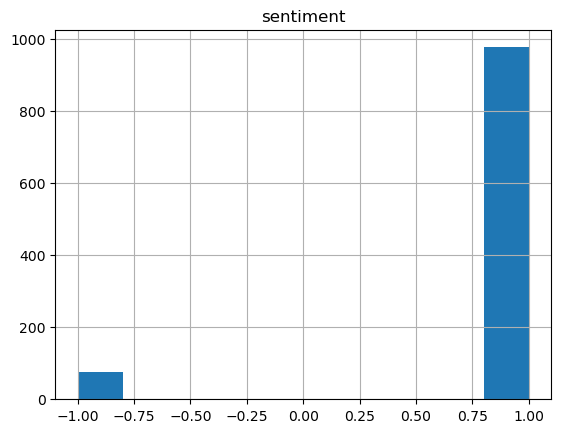

In [12]:
# View number of positive and negative sentiment
products.hist(column=['sentiment'])

Now, we can see that the dataset contains an extra column called **sentiment** which is either positive (+1) or negative (-1).

Note, there are significantly more positive reviews than negative reviews.

# Match number of positive and negative reviews

In [13]:
'''
# Report number of positive examples
positive_sent = products[products['sentiment']==1]
print('There are {} positive reviews'.format(len(positive_sent)))

# Report number of negative examples
negative_sent = products[products['sentiment']==-1]
print('There are {} negative reviews'.format(len(negative_sent)))

# Sample number of negative example from positive examples (# positive > # negative)
positive_sample = positive_sent.sample(n = len(negative_sent))
print('[Update] There are {} positive reviews'.format(len(positive_sample)))

# Merge positive and negative examples and update products dataframe
frames = [negative_sent, positive_sample]
products = pd.concat(frames)
print(products.head())
print(products.tail())
'''

"\n# Report number of positive examples\npositive_sent = products[products['sentiment']==1]\nprint('There are {} positive reviews'.format(len(positive_sent)))\n\n# Report number of negative examples\nnegative_sent = products[products['sentiment']==-1]\nprint('There are {} negative reviews'.format(len(negative_sent)))\n\n# Sample number of negative example from positive examples (# positive > # negative)\npositive_sample = positive_sent.sample(n = len(negative_sent))\nprint('[Update] There are {} positive reviews'.format(len(positive_sample)))\n\n# Merge positive and negative examples and update products dataframe\nframes = [negative_sent, positive_sample]\nproducts = pd.concat(frames)\nprint(products.head())\nprint(products.tail())\n"

## Split data into training and test sets

Let's perform a train/test split with 80% of the data in the training set and 20% of the data in the test set. We use `seed=1` so that everyone gets the same result.

In [14]:
from sklearn.model_selection import train_test_split

X, y = products.loc[:, ~products.columns.isin(['sentiment'])], products.loc[:, products.columns.isin(['sentiment'])]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)
print(len(X_train))
print(len(y_train))

842
842


In [15]:
X_train_sentiment = X_train.loc[:,X_train.columns.str.startswith('tfidf_word_count_')]
X_test_sentiment = X_test.loc[:,X_test.columns.str.startswith('tfidf_word_count_')]

X_train_sentiment.head()

tfidf_word_count_word_count_0  tfidf_word_count_word_count_1  \
867                              0                              0   
54                               0                              0   
455                              0                              0   
851                              0                              0   
84                               0                              0   

     tfidf_word_count_word_count_2  tfidf_word_count_word_count_3  \
867                              0                              0   
54                               0                              0   
455                              0                              0   
851                              0                              0   
84                               0                              0   

     tfidf_word_count_word_count_4  tfidf_word_count_word_count_5  \
867                              0                              0   
54                               0                              0   
455                              0                              0   
851                              0                              0   
84                               0                              0   

     tfidf_word_count_word_count_6  tfidf_word_count_word_count_7  \
867                              0                              0   
54                               0                              0   
455                              0                              0   
851                              0                              0   
84                               0                              0   

     tfidf_word_count_word_count_8  tfidf_word_count_word_count_9  ...  \
867                              0                              0  ...   
54                               0                              0  ...   
455                              0                              0  ...   
851                              0                              0  ...   
84                               0                              0  ...   

     tfidf_word_count_word_count_6740  tfidf_word_count_word_count_6741  \
867                                 0                                 0   
54                                  0                                 0   
455                                 0                                 0   
851                                 0                                 0   
84                                  0                                 0   

     tfidf_word_count_word_count_6742  tfidf_word_count_word_count_6743  \
867                                 0                                 0   
54                                  0                                 0   
455                                 0                                 0   
851                                 0                                 0   
84                                  0                                 0   

     tfidf_word_count_word_count_6744  tfidf_word_count_word_count_6745  \
867                                 0                                 0   
54                                  0                                 0   
455                                 0                                 0   
851                                 0                                 0   
84                                  0                                 0   

     tfidf_word_count_word_count_6746  tfidf_word_count_word_count_6747  \
867                                 0                                 0   
54                                  0                                 0   
455                                 0                                 0   
851                                 0                                 0   
84                                  0                                 0   

     tfidf_word_count_word_count_6748  tfidf_word_count_word_count_6749  
867                   

Just like in the earlier assignments, we convert Pandas dataframe into a NumPy array. Two arrays are returned: one representing features and another representing class labels. 

# Training Logistic Regression via Stochastic Gradient Ascent

The goal of this notebook is to implement a logistic regression classifier using stochastic gradient descent. 

To verify the correctness of the gradient computation, we provide a function for computing average log likelihood (which we recall from the last assignment was a topic detailed in an advanced optional video, and used here for its numerical stability).

To track the performance of stochastic gradient ascent, we provide a function for computing **average log likelihood**. 

$$\ell\ell_A(\mathbf{w}) = \color{black}{\frac{1}{N}} \sum_{i=1}^N \Big( (\mathbf{1}[y_i = +1] - 1)\mathbf{w}^T h(\mathbf{x}_i) - \ln\left(1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))\right) \Big) $$

**Note** that we made one tiny modification to the log likelihood function (called **compute_log_likelihood**) in our earlier assignments. We added a $\color{black}{1/N}$ term which averages the log likelihood accross all data points. The $\color{black}{1/N}$ term makes it easier for us to compare stochastic gradient ascent with batch gradient ascent. We will use this function to generate plots that are similar to those you saw in the lecture.

In [16]:
def compute_avg_log_likelihood(feature_matrix, sentiment, coefficients):
    '''
    Compute the average log-likelihood of logistic regression coefficients
    Input
        - feature_matrix: subset of features in dataset
        - sentiment: true sentiment of inputs
        - coefficients: logistic regression weights
    Output
        - lp: log likelihood estimation
    '''
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    logexp = np.log(1. + np.exp(-scores))
    
    # Simple check to prevent overflow
    mask = np.isinf(logexp)
    logexp[mask] = -scores[mask]
    
    lp = np.sum((indicator-1)*scores - logexp)/len(feature_matrix)
    
    return lp

In [17]:
def predict_probability(X, W, b=0):
    '''
    Produces probabilistic estimate for P(y_i = +1 | x_i, w)
        Estimate ranges between 0 and 1.
    Input:
        - X: Input features
        - W: weights/coefficients of logistic regression model
        - b: bias or y-intercept of logistic regression classifier
    Output:
        - y_pred: probability of positive product review
    '''
    # Take dot product of feature_matrix and coefficients  
    score = np.dot(X, W)
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    y_pred = 1. / (1.+np.exp(-score)) + b    
    return y_pred

In [18]:
 def predict(X, W, b):
    '''
    Hypothetical function  h(x)
    Input: 
        - X: Input features
        - W: weights/coefficients of logistic regression model
        - b: bias or y-intercept of logistic regression classifier
    Output:
        - Y: list of predicted classes 
    '''
    Z = 1 / (1 + np.exp(- (X.dot( W ) + b)))
    Y = [0 if z <=0.5 else 1 for z in Z]
    return Y 

In [19]:
j = 1                        # Feature number
i = 10                       # Data point start
B = 10                       # Mini-batch size
coefficients = np.zeros(X_train_sentiment.shape[1]) # A point w at which we are computing the gradient.

predictions = predict_probability(X_train_sentiment.iloc[i:i+B,:], coefficients)
indicator = (y_train.iloc[i:i+B]==+1)
indicator = [1 if i==True else 0 for i in indicator['sentiment']]

errors = indicator - predictions        
gradient_mini_batch = errors.dot(X_train_sentiment.iloc[i:i+B,j].T)
print("Gradient mini-batch data points: %s" % gradient_mini_batch)
print("                --> Should print 1.0")

Gradient mini-batch data points: 0.0
                --> Should print 1.0


In [20]:
from math import sqrt
def logistic_regression_SG(feature_matrix, y_true, initial_coefficients, batch_size, max_iter, learning_rate=0.01):
    '''
    Input
        - feature_matrix: input features
        - y_true: target variable (product sentiment)
        - initial_coefficients: list of coefficients 
        - batch_size: number of examples to use for updating weights
        - max_iter: number of iterations for gradient ascent
        - learning_rate: learning rate for gradient ascent
    Output
        - coefficients: model weights
        - b: model bias/intercept
        - log_likelihood_all: average log likilihood of weights
    '''
    log_likelihood_all = []
    
    # make sure it's a numpy array
    coefficients = np.array(initial_coefficients)
    # set seed=1 to produce consistent results
    np.random.seed(seed=1)
    # Shuffle the data before starting
    permutation = np.random.permutation(len(feature_matrix))
    feature_matrix = feature_matrix[permutation,:]
    sentiment = y_true[permutation]
    b=0
    
    i = 0 # index of current batch
    # Do a linear scan over data
    for itr in range(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,:]
        predictions = predict_probability(feature_matrix[i:i+batch_size,:], coefficients)
        
        # Compute indicator value for (y_i = +1)
        # Make sure to slice the i-th entry with [i:i+batch_size]
        indicator = (sentiment[i:i+batch_size]==+1)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        
        for j in range(len(coefficients)): # loop over each coefficient
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j]
            # Compute the derivative for coefficients[j] and save it to dW.
            # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,j]
            dW = errors.dot(feature_matrix[i:i+batch_size,j].T)
            
            # compute the product of the step size, the derivative, and the **normalization constant** (1./batch_size)
            coefficients[j] += learning_rate * dW 
        
        # Checking whether log likelihood is increasing
        # Print the log likelihood over the *current batch*
        lp = compute_avg_log_likelihood(feature_matrix[i:i+batch_size,:], y_true[i:i+batch_size],
                                        coefficients)

        log_likelihood_all.append(lp)
        if itr <= 15 or (itr <= 1000 and itr % 100 == 0) or (itr <= 10000 and itr % 1000 == 0) \
         or itr % 10000 == 0 or itr == max_iter-1:
            data_size = len(feature_matrix)
            print('Iteration %*d: Average log likelihood (of data points in batch [%0*d:%0*d]) = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, \
                 int(np.ceil(np.log10(data_size))), i, \
                 int(np.ceil(np.log10(data_size))), i+batch_size, lp))
        
        # if we made a complete pass over data, shuffle and restart
        i += batch_size
        if i+batch_size > len(feature_matrix):
            permutation = np.random.permutation(len(feature_matrix))
            feature_matrix = feature_matrix[permutation,:]
            sentiment = sentiment[permutation]
            i = 0
            learning_rate=learning_rate/1.02
                
    # We return the list of log likelihoods for plotting purposes.
    return coefficients, b, log_likelihood_all

In [22]:
init_weights=np.zeros(X_train_sentiment.shape[1])
num_iterations=500
batch_size=500
learning_rate=0.0001

sentiment_model_weights, sentiment_model_bias, log_likelihood = logistic_regression_SG(X_train_sentiment.to_numpy(), 
                                                      np.ravel(y_train), 
                                                      init_weights,
                                                      batch_size=batch_size, 
                                                      max_iter=num_iterations,
                                                      learning_rate=learning_rate)

Iteration   0: Average log likelihood (of data points in batch [000:500]) = -0.40001825
Iteration   1: Average log likelihood (of data points in batch [000:500]) = -0.52861795
Iteration   2: Average log likelihood (of data points in batch [000:500]) = -0.41039697
Iteration   3: Average log likelihood (of data points in batch [000:500]) = -0.46170082
Iteration   4: Average log likelihood (of data points in batch [000:500]) = -0.41912135
Iteration   5: Average log likelihood (of data points in batch [000:500]) = -0.51404861
Iteration   6: Average log likelihood (of data points in batch [000:500]) = -0.44853157
Iteration   7: Average log likelihood (of data points in batch [000:500]) = -0.49144797
Iteration   8: Average log likelihood (of data points in batch [000:500]) = -0.49065958
Iteration   9: Average log likelihood (of data points in batch [000:500]) = -0.44066958
Iteration  10: Average log likelihood (of data points in batch [000:500]) = -0.41909449
Iteration  11: Average log likel

In [23]:
num_positive_weights = np.sum(sentiment_model_weights >= 0)
num_negative_weights = np.sum(sentiment_model_weights < 0)

print("Number of positive weights: %s " % num_positive_weights)
print("Number of negative weights: %s " % num_negative_weights)

Number of positive weights: 5754 
Number of negative weights: 996 


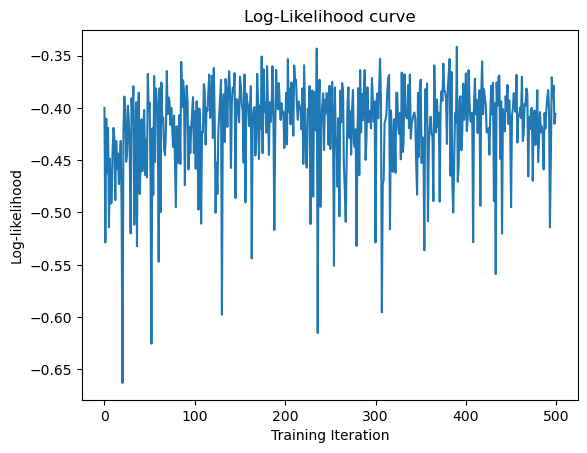

In [24]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(len(log_likelihood))], log_likelihood)
plt.title("Log-Likelihood curve")
plt.xlabel("Training Iteration")
plt.ylabel("Log-likelihood")
plt.show()

# Create SGD model using Sklearn

Define hyperparameters for training

In [25]:
loss='log_loss'         # 'log' is logistic regression
random_state=42         # seed of the pseudo random number generated which is used while shuffling the data
init_weights=np.zeros(X_train_sentiment.shape[1])
num_iterations=500
batch_size=500
learning_rate=0.0001

In [26]:
from sklearn.linear_model import SGDClassifier

# Create SGD model
sgd_model = SGDClassifier(max_iter=num_iterations, 
                          alpha=learning_rate,
                          loss=loss,
                          random_state=random_state)
sgd_model.fit(X_train_sentiment, np.ravel(y_train), coef_init=init_weights)

SGDClassifier(loss='log_loss', max_iter=500, random_state=42)

Inspect SGD coefficients

In [27]:
sgd_model.coef_

array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        1.29704914e-070, 0.00000000e+000, 1.29544012e-320]])

In [28]:
num_positive_weights = np.sum(sgd_model.coef_ >= 0)
num_negative_weights = np.sum(sgd_model.coef_ < 0)

print("Number of positive weights: %s " % num_positive_weights)
print("Number of negative weights: %s " % num_negative_weights)

Number of positive weights: 5760 
Number of negative weights: 990 


In [29]:
sgd_model.intercept_

array([7.77061219])

## Compute accuracy of the classifier

We will now evaluate the accuracy of the trained classifier. Recall that the accuracy is given by

$$
accuracy = \frac{\textnormal{number of correctly classified examples}}{\textnormal{number of total examples}}
$$
  
This can be computed as follows:

* **Step 1:** Use the trained model to compute class predictions (**Hint:** Use the `predict` method)
* **Step 2:** Count the number of data points when the predicted class labels match the ground truth labels (called `true_labels` below).
* **Step 3:** Divide the total number of correct predictions by the total number of data points in the dataset.

In [30]:
def get_classification_accuracy(prediction_labels, true_labels):
    # First get the predictions
    
    # Compute the number of correctly classified examples
    num_correct = np.sum(prediction_labels == true_labels)

    # Then compute accuracy by dividing num_correct by total number of examples
    accuracy = num_correct / len(true_labels)
    
    return accuracy

Performance of our LSG model on traning and test data

In [31]:
train_lg_accuracy = get_classification_accuracy(predict(X_train_sentiment, sentiment_model_weights, sentiment_model_bias), np.ravel(y_train))
print(train_lg_accuracy)

0.9263657957244655


In [32]:
test_lg_accuracy = get_classification_accuracy(predict(X_test_sentiment, sentiment_model_weights, sentiment_model_bias), np.ravel(y_test))
print(test_lg_accuracy)

0.9241706161137441


Performance of Sklearn LSG model on traning and test data

In [33]:
train_sklearn_accuracy = get_classification_accuracy(sgd_model.predict(X_train_sentiment), np.ravel(y_train))
print(train_sklearn_accuracy)

1.0


In [34]:
test_sklearn_accuracy = get_classification_accuracy(sgd_model.predict(X_test_sentiment), np.ravel(y_test))
print(test_sklearn_accuracy)

0.9383886255924171
